
=== Logistic Regression ===
Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        60
         Low       1.00      1.00      1.00       150
    Moderate       0.99      1.00      0.99        90

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300

Confusion Matrix:
          High  Low  Moderate
High        59    0         1
Low          0  150         0
Moderate     0    0        90


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


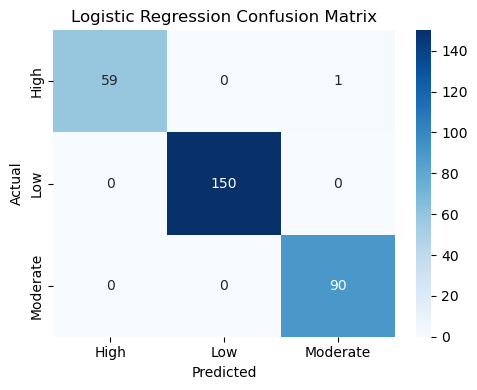


=== Random Forest ===
Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00        60
         Low       1.00      1.00      1.00       150
    Moderate       1.00      1.00      1.00        90

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300

Confusion Matrix:
          High  Low  Moderate
High        60    0         0
Low          0  150         0
Moderate     0    0        90


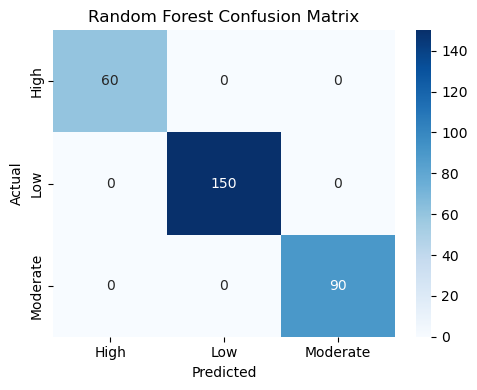


=== XGBoost ===
Classification Report:
              precision    recall  f1-score   support

        High       1.00      0.98      0.99        60
         Low       1.00      1.00      1.00       150
    Moderate       0.99      1.00      0.99        90

    accuracy                           1.00       300
   macro avg       1.00      0.99      1.00       300
weighted avg       1.00      1.00      1.00       300

Confusion Matrix:
          High  Low  Moderate
High        59    0         1
Low          0  150         0
Moderate     0    0        90


/opt/anaconda3/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [18:38:31] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


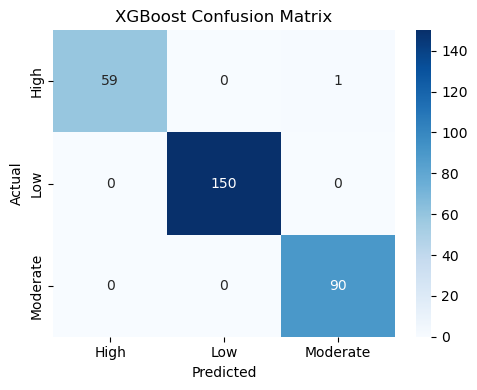

['./output/burnout_label_encoder.pkl']

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

# Ensure output directory exists
os.makedirs("./output", exist_ok=True)

# Load dataset
df = pd.read_csv("./data/simulated_weekly_burnout.csv")

# Encode categorical target
label_encoder = LabelEncoder()
df["burnout_label"] = label_encoder.fit_transform(df["burnout"])

# Define features
features = ['avg_tired', 'avg_capable', 'avg_meaningful']
X = df[features]
y = df["burnout_label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42
)

# Scale features (only for Logistic Regression)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize models
models = {
    "Logistic Regression": LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "XGBoost": XGBClassifier(
        objective='multi:softprob', num_class=3, eval_metric='mlogloss',
        use_label_encoder=False, random_state=42)
}

# Train, evaluate, and save each model
for name, model in models.items():
    print(f"\n=== {name} ===")
    
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    # Decode labels
    y_test_labels = label_encoder.inverse_transform(y_test)
    y_pred_labels = label_encoder.inverse_transform(y_pred)

    # Print metrics
    print("Classification Report:")
    print(classification_report(y_test_labels, y_pred_labels))

    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=label_encoder.classes_)
    print("Confusion Matrix:")
    print(pd.DataFrame(cm, index=label_encoder.classes_, columns=label_encoder.classes_))

    # Plot heatmap
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_)
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

    # Save the model
    safe_name = name.lower().replace(" ", "_")
    joblib.dump(model, f"./output/{safe_name}_model.pkl")

# Save preprocessing tools
joblib.dump(scaler, "./output/burnout_scaler.pkl")
joblib.dump(label_encoder, "./output/burnout_label_encoder.pkl")


In [19]:
import numpy as np
import joblib

def predict_burnout_for_user(avg_tired, avg_capable, avg_meaningful):
    # Load pre-trained models
    lr_model = joblib.load("./output/logistic_regression_model.pkl")
    rf_model = joblib.load("./output/random_forest_model.pkl")
    xgb_model = joblib.load("./output/xgboost_model.pkl")

    # Load preprocessing tools
    scaler = joblib.load("./output/burnout_scaler.pkl")
    label_encoder = joblib.load("./output/burnout_label_encoder.pkl")

    # Create input vector
    user_data = np.array([[avg_tired, avg_capable, avg_meaningful]])

    # Scale for Logistic Regression
    user_data_scaled = scaler.transform(user_data)

    print("=== Prediction for User Input ===")
    print(f"Input: tired={avg_tired}, capable={avg_capable}, meaningful={avg_meaningful}\n")

    # Predict using each model
    for name, model, X_input in [
        ("Logistic Regression", lr_model, user_data_scaled),
        ("Random Forest", rf_model, user_data),
        ("XGBoost", xgb_model, user_data)
    ]:
        prediction_encoded = model.predict(X_input)[0]
        prediction_label = label_encoder.inverse_transform([prediction_encoded])[0]
        print(f"{name} Prediction: {prediction_label}")


In [25]:
predict_burnout_for_user(avg_tired=5, avg_capable=5.0, avg_meaningful=4.5)

=== Prediction for User Input ===
Input: tired=5, capable=5.0, meaningful=4.5

Logistic Regression Prediction: Moderate
Random Forest Prediction: Moderate
XGBoost Prediction: Moderate


/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
